In this notebook we will follow a [PyTorch tutorial](https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/) implementing [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) with CIFAR10.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset
***

In [4]:
# Image preprocessing modules (see more about this later)
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='../cifar-10-batches-py/',
                                             train=True, 
                                             transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='../cifar-10-batches-py/',
                                            train=False, 
                                            transform=transforms.ToTensor())

In [18]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../cifar-10-batches-py/
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=4, fill=0, padding_mode=constant)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=None)
               ToTensor()
           )

In [19]:
type(train_dataset)

torchvision.datasets.cifar.CIFAR10

In [20]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [43]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../cifar-10-batches-py/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [21]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [6]:
import matplotlib.pyplot as plt

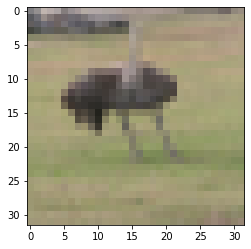

In [7]:
plt.figure()
plt.imshow(train_dataset.data[42])

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True) #Original tutorial has shuffle=True

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

In [48]:
train_loader

### Model
***

In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

In [30]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)  # 1 when using mnist, 3 when using cifar10
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    
    def make_layer(self, block, out_channels, blocks, stride=1):
        
        downsample = None
        
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

### Training and testing

In [42]:
def train_model(train_loader, num_epoch, model, error, optimizer, curr_lr, update_lr):
    print("Training model")
    print(f"Total epochs: {num_epoch}. Current learning rate: {curr_lr}")
    
    for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.resize_(100, 1, 32, 32).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = error(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
        
    return model

IndentationError: expected an indented block (<ipython-input-42-b1681609b042>, line 6)

In [43]:
def test_model(test_loader, model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.resize_(100, 1, 32, 32).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [37]:
# Hyper-parameters (attempt changing them later)
num_epochs = 80
learning_rate = 0.001

In [31]:
net_args = {
    "block" : ResidualBlock,
    "layers": [2, 2, 2]
}

model = ResNet(**net_args).to(device)

In [32]:
error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [34]:
total_step = len(train_loader)
curr_lr = learning_rate

In [38]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.resize_(100, 1, 32, 32).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = error(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/80], Step [100/500] Loss: 2.3057
Epoch [1/80], Step [200/500] Loss: 2.3005
Epoch [1/80], Step [300/500] Loss: 2.3031
Epoch [1/80], Step [400/500] Loss: 2.3033
Epoch [1/80], Step [500/500] Loss: 2.3057
Epoch [2/80], Step [100/500] Loss: 2.2999
Epoch [2/80], Step [200/500] Loss: 2.3021
Epoch [2/80], Step [300/500] Loss: 2.3047
Epoch [2/80], Step [400/500] Loss: 2.3029
Epoch [2/80], Step [500/500] Loss: 2.3016
Epoch [3/80], Step [100/500] Loss: 2.3040
Epoch [3/80], Step [200/500] Loss: 2.3014
Epoch [3/80], Step [300/500] Loss: 2.3014
Epoch [3/80], Step [400/500] Loss: 2.3028
Epoch [3/80], Step [500/500] Loss: 2.3034
Epoch [4/80], Step [100/500] Loss: 2.3042
Epoch [4/80], Step [200/500] Loss: 2.3072
Epoch [4/80], Step [300/500] Loss: 2.3004
Epoch [4/80], Step [400/500] Loss: 2.3043
Epoch [4/80], Step [500/500] Loss: 2.3006
Epoch [5/80], Step [100/500] Loss: 2.2984
Epoch [5/80], Step [200/500] Loss: 2.3048
Epoch [5/80], Step [300/500] Loss: 2.3076
Epoch [5/80], Step [400/500] Loss:

Epoch [39/80], Step [300/500] Loss: 2.3026
Epoch [39/80], Step [400/500] Loss: 2.3032
Epoch [39/80], Step [500/500] Loss: 2.3024
Epoch [40/80], Step [100/500] Loss: 2.3029
Epoch [40/80], Step [200/500] Loss: 2.3025
Epoch [40/80], Step [300/500] Loss: 2.3026
Epoch [40/80], Step [400/500] Loss: 2.3030
Epoch [40/80], Step [500/500] Loss: 2.3027
Epoch [41/80], Step [100/500] Loss: 2.3022
Epoch [41/80], Step [200/500] Loss: 2.3021
Epoch [41/80], Step [300/500] Loss: 2.3023
Epoch [41/80], Step [400/500] Loss: 2.3029
Epoch [41/80], Step [500/500] Loss: 2.3029
Epoch [42/80], Step [100/500] Loss: 2.3025
Epoch [42/80], Step [200/500] Loss: 2.3025
Epoch [42/80], Step [300/500] Loss: 2.3023
Epoch [42/80], Step [400/500] Loss: 2.3028
Epoch [42/80], Step [500/500] Loss: 2.3030
Epoch [43/80], Step [100/500] Loss: 2.3026
Epoch [43/80], Step [200/500] Loss: 2.3026
Epoch [43/80], Step [300/500] Loss: 2.3023
Epoch [43/80], Step [400/500] Loss: 2.3031
Epoch [43/80], Step [500/500] Loss: 2.3027
Epoch [44/8

Epoch [77/80], Step [400/500] Loss: 2.3026
Epoch [77/80], Step [500/500] Loss: 2.3026
Epoch [78/80], Step [100/500] Loss: 2.3026
Epoch [78/80], Step [200/500] Loss: 2.3026
Epoch [78/80], Step [300/500] Loss: 2.3026
Epoch [78/80], Step [400/500] Loss: 2.3026
Epoch [78/80], Step [500/500] Loss: 2.3026
Epoch [79/80], Step [100/500] Loss: 2.3025
Epoch [79/80], Step [200/500] Loss: 2.3025
Epoch [79/80], Step [300/500] Loss: 2.3026
Epoch [79/80], Step [400/500] Loss: 2.3025
Epoch [79/80], Step [500/500] Loss: 2.3026
Epoch [80/80], Step [100/500] Loss: 2.3026
Epoch [80/80], Step [200/500] Loss: 2.3026
Epoch [80/80], Step [300/500] Loss: 2.3026
Epoch [80/80], Step [400/500] Loss: 2.3025
Epoch [80/80], Step [500/500] Loss: 2.3026


In [36]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.resize_(100, 1, 32, 32).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 10.24 %


In [44]:
test_model(test_loader, model)

Accuracy of the model on the test images: 10.0 %


In [77]:
torch.save(model.state_dict(), 'resnet_cifar10_v1.ckpt')

***
<span style="color: blue"><b>Study session observations: </b></span>

<!-- #### 16/07/2020:
Attempting to use the same resnet model to train CIFAR10. -->

#### 17/07/2020-20/07/2020:
Both models (with 3 layers) had a accuracy of ~10%. 